In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
#Reading data
df = pd.read_csv('diabetes_prediction_dataset.csv')
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [3]:
df.isnull().sum()#check the data is clean

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [4]:
df.duplicated().sum()#check If there is duplication

3854

In [5]:
df.drop_duplicates(inplace=True)#remove the duplicated data

In [6]:
df.duplicated().sum()

0

In [7]:
df['gender'] = df['gender'].astype('category')
df['smoking_history'] = df['smoking_history'].astype('category')

In [8]:
#EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96146 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   gender               96146 non-null  category
 1   age                  96146 non-null  float64 
 2   hypertension         96146 non-null  int64   
 3   heart_disease        96146 non-null  int64   
 4   smoking_history      96146 non-null  category
 5   bmi                  96146 non-null  float64 
 6   HbA1c_level          96146 non-null  float64 
 7   blood_glucose_level  96146 non-null  int64   
 8   diabetes             96146 non-null  int64   
dtypes: category(2), float64(3), int64(4)
memory usage: 6.1 MB


In [10]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000
mean,41.794326,0.077601,0.040803,27.321461,5.532609,138.218231,0.088220
std,22.462948,0.267544,0.197833,6.767716,1.073232,40.909771,0.283616
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


In [11]:
df.describe(include='category')

,gender,smoking_history
count,96146,96146
unique,3,6
top,Female,never
freq,56161,34398


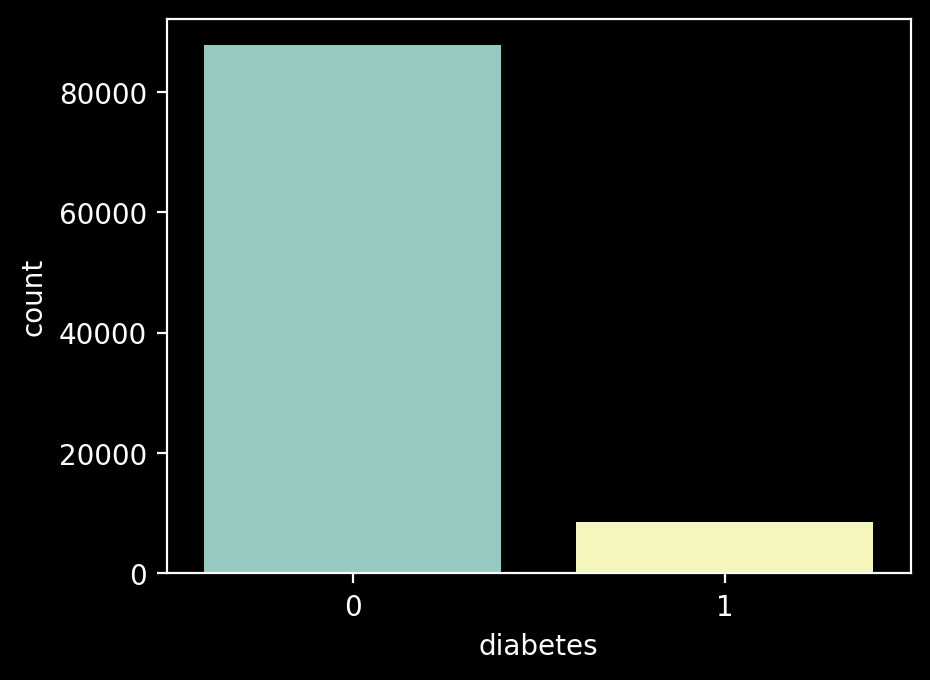

In [12]:
#See how many people have diabetes
sns.countplot(data=df,x='diabetes');

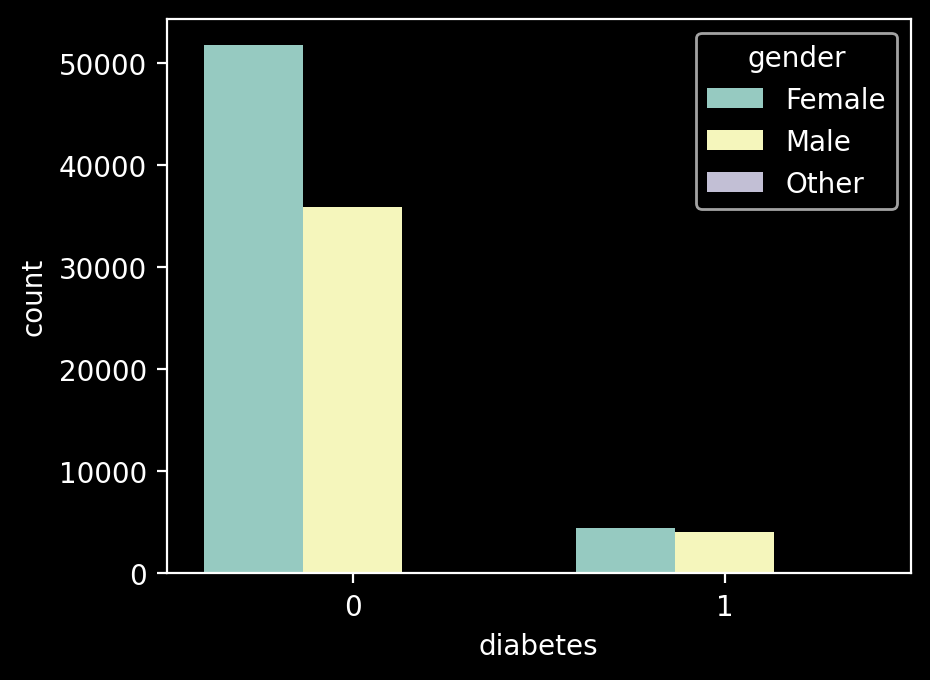

In [13]:
#See how many people have diabetes with gender
sns.countplot(data=df,x='diabetes',hue='gender');

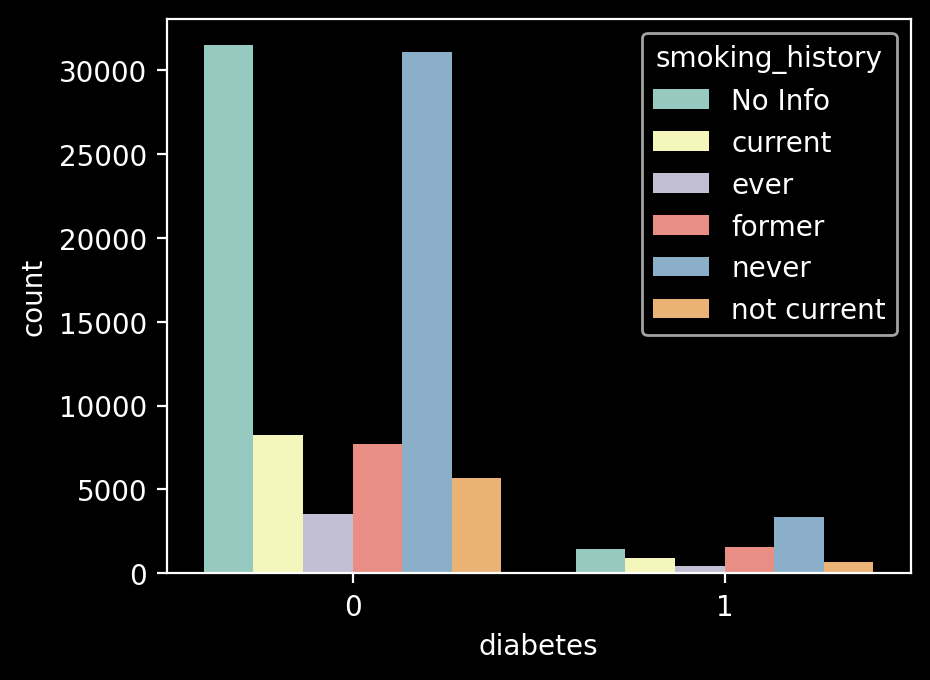

In [14]:
#See how many people have diabetes with smoke  history
sns.countplot(data=df,x='diabetes',hue='smoking_history');

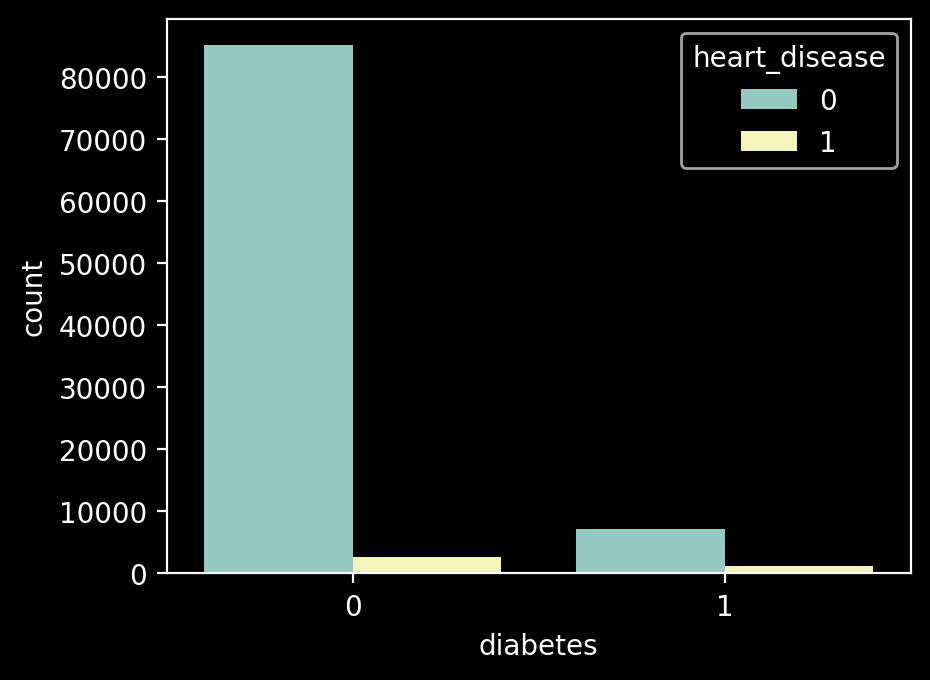

In [15]:
#See how many people have diabetes with heart disease
sns.countplot(data=df,x='diabetes',hue='heart_disease');

In [16]:
#Decision tree Manually

In [17]:
#Entropy Equation
#E - Pi * log2(Pi)
def entropy(target_col):
    elements, counts = np.unique(target_col,return_counts=True)
    
    entropy = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    
    return entropy    

In [18]:
def info_gain(data, split_attribute,target_name):
    
    total_entropy = entropy(data[target_name])
    
    vals , counts = np.unique(data[split_attribute], return_counts=True)
    
    weigted_entropy = np.sum([(counts[i]/np.sum(counts)) * entropy(data.where(data[split_attribute] == vals[i]).dropna()[target_name]) for i in range(len(vals))])
    
    information_gain = total_entropy - weigted_entropy
    
    return information_gain

In [19]:
def id3(data, original_data, features, target_attribute, parent_node_class = None):
    
    if len(np.unique(data[target_attribute])) <= 1:
        return np.unique(data[target_attribute])[0]
    
    elif len(data) == 0:
        return np.unique(original_data[target_attribute])[np.argmax(np.unique(original_data[target_attribute], return_counts=True)[1])]
    
    elif len(features) == 0:
        return parent_node_class
    
    else:
        parent_node_class = np.unique(data[target_attribute])[
            np.argmax(np.unique(data[target_attribute], return_counts=True)[1])
        ]
        
    item_values = [info_gain(data,feature,target_attribute) for feature in features]
    
    best_feature_index = np.argmax(item_values)
    best_feature = features[best_feature_index]
    
    tree = {best_feature:{}}
    
    features = [i for i in features if i != best_feature]
    
    for value in np.unique(data[best_feature]):
        sub_data = data.where(data[best_feature] == value).dropna()
        subtree = id3(sub_data,original_data,features,target_attribute,parent_node_class)
        
        tree[best_feature][value] = subtree
        
    return tree

In [25]:
def predict(query,tree,default='0'):
    for key in query.keys():
        if key in tree.keys():
            try:
                result = tree[key][query[key]]
            except:
                return default
            
            if isinstance(result,dict):
                return predict(query,result)
            else:
                return result

In [21]:
def classify(tree,df):
    queries = df.to_dict(orient='records')
    predicted = []
    for query in queries:
        predicted.append(predict(query,tree))
    return predicted

In [22]:
train = df[:80000]
test = df[80000:]

In [23]:
features = [i for i in df.columns if i != 'diabetes']
target = 'diabetes'
tree = id3(train,train,features,target)
print(tree)

{'HbA1c_level': {3.5: 0.0, 4.0: 0.0, 4.5: 0.0, 4.8: 0.0, 5.0: 0.0, 5.7: {'bmi': {10.3: 0.0, 10.77: 0.0, 11.43: 0.0, 11.85: 0.0, 11.88: 0.0, 12.33: 0.0, 12.36: 0.0, 12.47: 0.0, 12.53: 0.0, 12.58: 0.0, 12.65: 0.0, 12.92: 0.0, 12.93: 0.0, 13.04: 0.0, 13.12: 0.0, 13.22: 0.0, 13.33: 0.0, 13.37: 0.0, 13.39: 0.0, 13.41: 0.0, 13.45: 0.0, 13.47: 0.0, 13.5: 0.0, 13.52: 0.0, 13.56: 0.0, 13.73: 0.0, 13.77: 0.0, 13.81: 0.0, 13.83: 0.0, 13.87: 0.0, 13.9: 0.0, 13.91: 0.0, 13.94: 0.0, 13.95: 0.0, 13.98: 0.0, 14.0: 0.0, 14.03: 0.0, 14.04: 0.0, 14.05: 0.0, 14.09: 0.0, 14.1: 0.0, 14.12: 0.0, 14.14: 0.0, 14.15: 0.0, 14.17: 0.0, 14.21: 0.0, 14.26: 0.0, 14.27: 0.0, 14.3: 0.0, 14.33: 0.0, 14.35: 0.0, 14.37: 0.0, 14.39: 0.0, 14.4: 0.0, 14.41: 0.0, 14.42: 0.0, 14.45: 0.0, 14.49: 0.0, 14.5: 0.0, 14.58: 0.0, 14.6: 0.0, 14.63: 0.0, 14.66: 0.0, 14.67: 0.0, 14.7: 0.0, 14.71: 0.0, 14.75: 0.0, 14.76: 0.0, 14.77: 0.0, 14.78: 0.0, 14.79: 0.0, 14.8: 0.0, 14.83: 0.0, 14.84: 0.0, 14.85: 0.0, 14.86: 0.0, 14.9: 0.0, 14.92: 

In [26]:
predictions = classify(tree,test)
print(predictions)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, '0', 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, '0', 0.0, 0.0, '0', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, '0', 1.0, 0.0, '0', 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, '0', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, '0', 0.0, '0', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, '0', 0.0, 0.0, '0', 0.0, '0', 0.0, 0.0, 0.0, '0', '0', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, '0', 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, '0', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, '0', 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, '0', 0.0, 0.0, 0.0, '0', 0.0, 0.0, 0.0, 1.0, 0.0, '0', 0.0, 0.0, 0.0, '0', '0', 0.0, 0.0, 0.0, '0', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, '0', 0.0, 0.0, 0.0, '0', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, '0', 0.0, '0', '0',

In [27]:
predictions = pd.DataFrame(predictions,columns=['predictions'])
predictions = predictions.astype('int')
predictions

,predictions
0,0
1,0
2,0
3,0
4,0
...,...
16141,0
16142,1
16143,0
16144,0


In [28]:
predictions['Actual'] = np.array(test['diabetes'])
predictions

,predictions,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
16141,0,0
16142,1,0
16143,0,0
16144,0,0


In [31]:
print('classification report for decision tree manually:')
print(classification_report(predictions['predictions'],predictions['Actual']))

(classification report for decision tree manually:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     15072
           1       0.52      0.71      0.60      1074

    accuracy                           0.94     16146
   macro avg       0.75      0.83      0.78     16146
weighted avg       0.95      0.94      0.94     16146



In [32]:
#Decision tree by scikit-learn

In [33]:
le = LabelEncoder()
for i in ['gender','smoking_history']:
    le.fit(df[i]).classes_
    df[i] = le.transform(df[i])

In [34]:
dt = DecisionTreeClassifier()

In [35]:
x = df.drop(['diabetes'],axis=1)
y = df['diabetes']

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=23)

In [37]:
dt.fit(x_train,y_train)

DecisionTreeClassifier()

In [44]:
predictions_scikit_learn = dt.predict(x_test)
predictions_scikit_learn

array([0, 0, 0, ..., 0, 0, 0])

In [46]:
print('classification report for decision tree by scikit-learn:')
print(classification_report(predictions_scikit_learn,y_test))

classification report for decision tree by scikit-learn:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     17483
           1       0.73      0.70      0.71      1747

    accuracy                           0.95     19230
   macro avg       0.85      0.84      0.84     19230
weighted avg       0.95      0.95      0.95     19230

